In [127]:
import folium
import pystac_client
import pandas as pd
import geopandas as gpd
import planetary_computer
import dask.dataframe as dd
import matplotlib.pyplot as plt
from pathlib import Path
#from sqlalchemy import text, create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Understanding the problem

Forest inventory data, which tells us the locations, species, heights, and more, are important data for learning about and managing out natural environment. Forest inventory data can tell us about how wildfires will spread, how much carbon is stored in a forest, how much timber can be harvested, where endangered species live, and more. New techniques in remote sensing and machine learning have opened the doors to new ways of collecting and analyzing forest inventory data, but there are still many challenges to overcome.

The goal of this data challenge is to use a massive database of forest inventory data, the FIA database, to predict the size and species composition of trees in a forest from the [Sycan Marsh Preserve in Eastern Oregon](https://www.nature.org/en-us/get-involved/how-to-help/places-we-protect/sycan-marsh/). The Sycan Marsh Preserve is an important study site and management area for the implementation of prescribed fire. Here, we learn about the impacts of wildfire on the landscape, and what we can do about it, [in the most dramatic form](https://www.nytimes.com/2022/01/05/climate/fire-forest-management-bootleg-oregon.html).

In 2018 and 2021 we collected Aerial LIDAR data (ALS) and field data at the Sycan Marsh Preserve. The ALS data is a point cloud of the forest canopy. We can use this point cloud, and a technique called Individual Tree Detection (ITD) to identify individual trees in the forest. Below, we show a map of all of the individual trees that we detected using the ALS data. Click on a tree to learn what we know about it.

In [72]:
# Load the detected trees from the ALS data into a geopandas dataframe
epsg_code = "EPSG:4326"
trees2 = pd.read_csv('data/als_trees.csv')
trees = gpd.GeoDataFrame(trees2, geometry=gpd.points_from_xy(trees.y, trees.x), crs=epsg_code)

In [74]:
print(trees2)

               x          y         HT
0    -121.137628  42.867440  15.114830
1    -121.137541  42.867414  31.279529
2    -121.137688  42.867394  48.300526
3    -121.137394  42.867361  18.999344
4    -121.137296  42.867362  20.045932
...          ...        ...        ...
2252 -121.138054  42.863501  50.269030
2253 -121.137893  42.863449  65.206695
2254 -121.138101  42.863428  68.736879
2255 -121.138003  42.863429  52.237534
2256 -121.137954  42.863421  57.470474

[2257 rows x 3 columns]


In [73]:
print(trees)

               x          y         HT                     geometry
0    -121.137628  42.867440  15.114830  POINT (42.86744 -121.13763)
1    -121.137541  42.867414  31.279529  POINT (42.86741 -121.13754)
2    -121.137688  42.867394  48.300526  POINT (42.86739 -121.13769)
3    -121.137394  42.867361  18.999344  POINT (42.86736 -121.13739)
4    -121.137296  42.867362  20.045932   POINT (42.86736 -121.1373)
...          ...        ...        ...                          ...
2252 -121.138054  42.863501  50.269030   POINT (42.8635 -121.13805)
2253 -121.137893  42.863449  65.206695  POINT (42.86345 -121.13789)
2254 -121.138101  42.863428  68.736879   POINT (42.86343 -121.1381)
2255 -121.138003  42.863429  52.237534    POINT (42.86343 -121.138)
2256 -121.137954  42.863421  57.470474  POINT (42.86342 -121.13795)

[2257 rows x 4 columns]


In [94]:
# Add the trees to a folium map
fmap = folium.Map(location=[trees.y.mean(), trees.x.mean()], zoom_start=17)
tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='esri'
)
tile.add_to(fmap)

def make_circle(p) -> None:
    circ = folium.CircleMarker(
        location=(p["y"], p["x"]),
        radius=2, 
        weight=1,
        popup=f"<b>Height:</b> {p['HT']:.2f}ft",
    )
    circ.add_to(fmap)

x = trees.apply(make_circle, axis=1)
print(x)

#trees.apply(lambda p: folium.CircleMarker(
#    location=(p["y"], p["x"]),
#    radius=2, 
#    weight=1,
#    popup=f"<b>Height:</b> {p.HT:.2f}ft",
#).add_to(fmap), axis=1)

fmap

0       None
1       None
2       None
3       None
4       None
        ... 
2252    None
2253    None
2254    None
2255    None
2256    None
Length: 2257, dtype: object


Pretty cool that we can see all this, huh? Did you click on any of the circles representing trees?

You probably saw that besides a tree's location, the tree's height is the only other thing we learn about the tree from the ALS data. But, for many of the problems that we're interested in using the tree inventory data to solve that's not quite good enough. For example, we're also especially interested in the diameter, the crown base height, and the species of the tree. These are all important variables for estimating how much biomass or carbon is stored in a tree, and, by extension, the forest.  

To get these other variables, we'll want to use what we know, a tree's height and location, as well as additional data, in order to predict the other variables that we're interested in, like diameter, crown base height, and species.

## FIA Database

Fortunately for us, there is an enormous database of tree observations called the FIA database. FIA (Forest Inventory and Analysis) is a program of the US Forest Service that collects data on the nation's forests. The FIA database contains information on the species, height, diameter, and much more for millions of trees across the United States.  

The FIA database is publicly available through the [FIA DataMart](https://apps.fs.usda.gov/fia/datamart/datamart.html), and is [heavily documented](https://research.fs.usda.gov/sites/default/files/2023-11/wo-fiadb_user_guide_p2_9-1_final.pdf). The documentation on what data is available in the FIA database is quite extensive, and it's worth taking a look at it to understand what data is available–especially when we start to consider which data we might want to use to predict the variables we're interested in.

Let's query the FIA database for tree observations that may be relevant to our area of interest. 

### ECOSUBCD

Ecological subsection codes (ECOSUBCD) describe an area of similar surficial geology, lithology, geomorphic
process, soil groups, subregional climate, and potential natural communities. You can read more about how these codes are defined [here](http://www.treesearch.fs.fed.us/pubs/48672).

We'll start our analysis by determining which ECOSUBCD represents the Sycan Marsh Preserve. We'll then use this to query the FIA database for tree observations in this subsection.

In [95]:
# Load the ecological subsections codes map
ecosubcd_map2 = gpd.read_file("data/S_USA.EcomapSubsections.shp")
ecosubcd_map = ecosubcd_map2.to_crs(epsg=4326)

# Load the 2A Unit polygon
unit_2a = gpd.read_file("data/2a_unit.geojson")
unit_2a.to_crs(crs=ecosubcd_map.crs, inplace=True)

# Find the ecological subsections that intersect with the 2A Unit
ecosubcd_map_2a = gpd.overlay(unit_2a, ecosubcd_map, how="intersection")

# Get the value from the MAP_UNIT_S column
ecosubcode_for_unit_2a = str(ecosubcd_map_2a["MAP_UNIT_S"][0])
print(f"Our ECOSUBCD is: {ecosubcode_for_unit_2a}")

Our ECOSUBCD is: M242Ce


In [108]:
# ecosubcd_map[ecosubcd_map["MAP_UNIT_S"] == "M242Ce"]
ecosubcd_map_2a.columns

Index(['OBJECTID', 'Id', 'Burn_Unit', 'Acres', 'Perim_', 'ORIG_OID', 'Unit',
       'Priority', 'Shape_Leng', 'Shape_Area', 'MAP_TYPE', 'MAP_LEVEL',
       'PROJECT', 'MAP_UNIT_S', 'MAP_UNIT_N', 'SUBSECTION', 'SUBSECTI_1',
       'AREA', 'PERIMETER', 'ACRES', 'GIS_ACRES', 'GIS_MILES', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

### FIA Database Query

Now let's use that ECOSUBCD to query all the tree observations in the FIA database from the same ecological subsection. The FIA DataBase is a 70GB SQLite database, so rather than downloading the database and querying it locally, we access the database through the [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/dataset/fia).

**Notes:**
1. This is a complicated query involving two tables: the PLOT and TREE tables.
2. This will take long time to run (it around 15 minutes for me). What a great opportunity to look through the FIA database documentation and see what the PLOT and TREE tables contain! Also, get up and give your dog a belly rub.

In [131]:
print(type(ecosubcode_for_unit_2a))

<class 'str'>


In [144]:
# Connect to the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
fia = catalog.get_collection("fia")

# Get the items for the PLOT and TREE tables
plot_item = fia.get_item("plot")
tree_item = fia.get_item("tree")

# Read the PLOT data, filtering for the desired ECOSUBCD
plot = dd.read_parquet(
    plot_item.assets["data"].href,
    columns=["CN", "ECOSUBCD"],
    storage_options=plot_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
    # filters=[("ECOSUBCD", "==", ecosubcode_for_unit_2a)]
)
plot = plot[
    plot["ECOSUBCD"].notnull()
    & (plot["ECOSUBCD"] == ecosubcode_for_unit_2a)
]

"""
# Read the TREE data
tree = dd.read_parquet(
    tree_item.assets["data"].href,
    storage_options=tree_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow"
)

# Perform the join
result = tree.merge(plot.rename(columns={"CN": "PLT_CN"}), on="PLT_CN")

# Compute the result and save to CSV
result.compute().to_csv("data/fia_query.csv", index=False)

print("Data has been saved to fia_query.csv")"""

'\n# Read the TREE data\ntree = dd.read_parquet(\n    tree_item.assets["data"].href,\n    storage_options=tree_item.assets["data"].extra_fields["table:storage_options"],\n    engine="pyarrow"\n)\n\n# Perform the join\nresult = tree.merge(plot.rename(columns={"CN": "PLT_CN"}), on="PLT_CN")\n\n# Compute the result and save to CSV\nresult.compute().to_csv("data/fia_query.csv", index=False)\n\nprint("Data has been saved to fia_query.csv")'

In [143]:
print(sorted(plot["ECOSUBCD"].unique().fillna("   ").compute()))

['   ', ' 211Aa', ' 211Ab', ' 211Ba', ' 211Bb', ' 211Ca', ' 211Cb', ' 211Da', ' 211Db', ' 211Dc', ' 211Ea', ' 211Eb', ' 211Ec', ' 211Ed', ' 211Ee', ' 211Fa', ' 211Fb', ' 211Fc', ' 211Fd', ' 211Ff', ' 211Ga', ' 211Gb', ' 211Ia', ' 211Ib', ' 211Ja', ' 211Jb', ' 211Jc', ' 211Jd', ' 212Ha', ' 212Hb', ' 212Hc', ' 212Hd', ' 212He', ' 212Hf', ' 212Hg', ' 212Hh', ' 212Hi', ' 212Hj', ' 212Hk', ' 212Hl', ' 212Hm', ' 212Jb', ' 212Jc', ' 212Jo', ' 212Ka', ' 212Kb', ' 212La', ' 212Lb', ' 212Lc', ' 212Ld', ' 212Le', ' 212Ma', ' 212Mb', ' 212Na', ' 212Nb', ' 212Nc', ' 212Nd', ' 212Qa', ' 212Qb', ' 212Qc', ' 212Qd', ' 212Ra', ' 212Rb', ' 212Rc', ' 212Rd', ' 212Re', ' 212Sb', ' 212Sc', ' 212Sn', ' 212Sq', ' 212Ta', ' 212Tb', ' 212Tc', ' 212Te', ' 212Tf', ' 212Xa', ' 212Xb', ' 212Xc', ' 212Xd', ' 212Xe', ' 212Xf', ' 212Xq', ' 212Ya', ' 212Za', ' 212Zb', ' 212Zc', ' 221Aa', ' 221Ab', ' 221Ac', ' 221Ad', ' 221Ae', ' 221Af', ' 221Ag', ' 221Ah', ' 221Ai', ' 221Ak', ' 221Al', ' 221Am', ' 221An', ' 221Ba', ' 

If you do manage to download the database from the FIA DataMart. The code below will perform the SQL query directly.

In [35]:
# fia_db_path = Path("path/to/fia/database/SQLite_FIADB_ENTIRE.db")

# Create an engine to connect to the SQLite database
# engine = create_engine(f"sqlite:///{fia_db_path}")

# Connect to the database
# connection = engine.connect()

# Define the SQL query
# query = text(
#     f"""
# SELECT TREE.*
# FROM PLOT
# JOIN TREE ON PLOT.CN = TREE.PLT_CN
# WHERE PLOT.ECOSUBCD = '{ecosubcode_for_unit_2a}';
# """
# )

# Execute the query
# df = pd.read_sql(query, engine)
# df.to_csv("tree_data.csv", index=False)


### Examine the data

In [6]:
fia_data = pd.read_csv('data/fia_query.csv', low_memory=False)

In [6]:
fia_data

CN          PLT_CN   PREV_TRE_CN  INVYR  STATECD  UNITCD  \
0      177347060020004  30763576020004  2.407351e+13   2012       41       3   
1      177347061020004  30763576020004  2.407351e+13   2012       41       3   
2      177347062020004  30763576020004  2.407351e+13   2012       41       3   
3      177347063020004  30763576020004  2.407351e+13   2012       41       3   
4      177347064020004  30763576020004           NaN   2012       41       3   
...                ...             ...           ...    ...      ...     ...   
67303   42208999010497  41118750010497           NaN   2002       41       3   
67304   42209000010497  41118750010497           NaN   2002       41       3   
67305   42209001010497  41118750010497           NaN   2002       41       3   
67306   42209002010497  41118750010497           NaN   2002       41       3   
67307   42209003010497  41118750010497           NaN   2002       41       3   

       COUNTYCD   PLOT  SUBP  TREE  ...  CULTURALLY_KILLED_PNWRS  \
0            35  50802     1   100  ...                      NaN   
1            35  50802     1   102  ...                      NaN   
2            35  50802     1   103  ...                      NaN   
3            35  50802     1   104  ...                      NaN   
4            35  50802     1   114  ...                      NaN   
...         ...    ...   ...   ...  ...                      ...   
67303        17  64144     4   134  ...                      NaN   
67304        17  64144     4   135  ...                      NaN   
67305        17  64144     4   136  ...                      NaN   
67306        17  64144     4   137  ...                      NaN   
67307        17  64144     4   138  ...                      NaN   

       DIA_EST_PNWRS  GST_PNWRS  INC10YR_PNWRS  INC5YRHT_PNWRS  INC5YR_PNWRS  \
0                NaN        NaN            NaN             NaN           NaN   
1                NaN        NaN            NaN             NaN           NaN   
2                NaN        NaN            NaN             NaN           NaN   
3                NaN        NaN            NaN             NaN           NaN   
4                NaN        NaN            NaN             NaN           NaN   
...              ...        ...            ...             ...           ...   
67303            NaN        NaN            NaN             NaN           NaN   
67304            NaN        NaN            NaN             NaN           NaN   
67305            NaN        NaN            NaN             NaN           NaN   
67306            NaN        NaN            NaN             NaN           NaN   
67307            NaN        NaN            NaN             NaN           NaN   

       RING_COUNT_INNER_2INCHES_PNWRS  RING_COUNT_PNWRS  SNAG_DIS_CD_PNWRS  \
0                                 NaN               NaN                NaN   
1                                 NaN               NaN                NaN   
2                                 NaN               NaN                NaN   
3                                 NaN               NaN                NaN   
4                                 NaN               NaN                NaN   
...                               ...               ...                ...   
67303                             NaN               NaN                NaN   
67304                             NaN               NaN                NaN   
67305                             NaN               NaN                NaN   
67306                             NaN               NaN                NaN   
67307                             NaN               NaN                NaN   

       ECOSUBCD  
0        M242Ce  
1        M242Ce  
2        M242Ce  
3        M242Ce  
4        M242Ce  
...         ...  
67303    M242Ce  
67304    M242Ce  
67305    M242Ce  
67306    M242Ce  
67307    M242Ce  

[67308 rows x 208 columns]

In [109]:
list(fia_data.columns)

['CN',
 'PLT_CN',
 'PREV_TRE_CN',
 'INVYR',
 'STATECD',
 'UNITCD',
 'COUNTYCD',
 'PLOT',
 'SUBP',
 'TREE',
 'CONDID',
 'AZIMUTH',
 'DIST',
 'PREVCOND',
 'STATUSCD',
 'SPCD',
 'SPGRPCD',
 'DIA',
 'DIAHTCD',
 'HT',
 'HTCD',
 'ACTUALHT',
 'TREECLCD',
 'CR',
 'CCLCD',
 'TREEGRCD',
 'AGENTCD',
 'CULL',
 'DAMLOC1',
 'DAMTYP1',
 'DAMSEV1',
 'DAMLOC2',
 'DAMTYP2',
 'DAMSEV2',
 'DECAYCD',
 'STOCKING',
 'WDLDSTEM',
 'VOLCFNET',
 'VOLCFGRS',
 'VOLCSNET',
 'VOLCSGRS',
 'VOLBFNET',
 'VOLBFGRS',
 'VOLCFSND',
 'GROWCFGS',
 'GROWBFSL',
 'GROWCFAL',
 'MORTCFGS',
 'MORTBFSL',
 'MORTCFAL',
 'REMVCFGS',
 'REMVBFSL',
 'REMVCFAL',
 'DIACHECK',
 'MORTYR',
 'SALVCD',
 'UNCRCD',
 'CPOSCD',
 'CLIGHTCD',
 'CVIGORCD',
 'CDENCD',
 'CDIEBKCD',
 'TRANSCD',
 'TREEHISTCD',
 'DIACALC',
 'BHAGE',
 'TOTAGE',
 'CULLDEAD',
 'CULLFORM',
 'CULLMSTOP',
 'CULLBF',
 'CULLCF',
 'BFSND',
 'CFSND',
 'SAWHT',
 'BOLEHT',
 'FORMCL',
 'HTCALC',
 'HRDWD_CLUMP_CD',
 'SITREE',
 'CREATED_BY',
 'CREATED_DATE',
 'CREATED_IN_INSTANCE',
 'MOD

As I said, there is an incredible amount of information here.

Let's start by looking at some initial relationships.

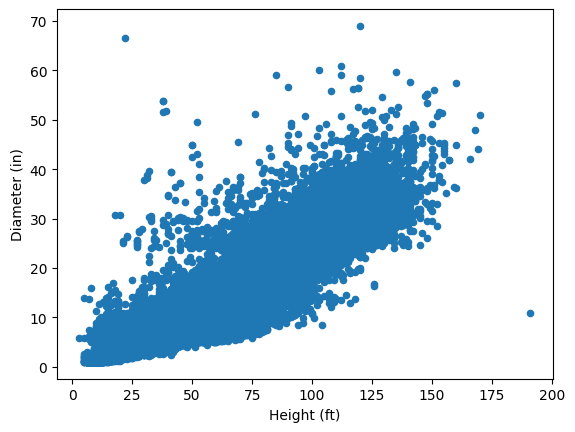

In [7]:
# Plot the relationship between tree height and diameter. I'll cut of DIA at 75 inches because there are some outliers.
fig, ax = plt.subplots()
fia_data[fia_data.DIA < 75].plot.scatter(x="HT", y="DIA", ax=ax)
ax.set_xlabel("Height (ft)")
ax.set_ylabel("Diameter (in)")
plt.show()

It looks like a tree's height and diameter are related. This is good news for us, because we can use a tree's height to predict its diameter. This is a common relationship in forestry, and there are many models that can be used to predict a tree's diameter from its height.

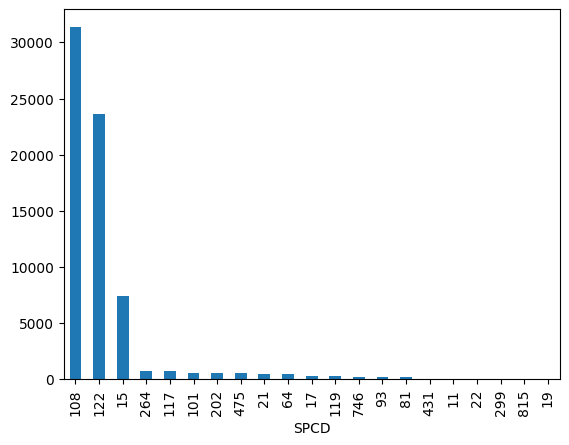

In [8]:
# Look at the distribution of tree species
fia_data["SPCD"].value_counts().plot(kind="bar")
plt.show()

It looks like the vast majority of species present in this ecological subsection are lodgepole pine (Pinus contorta), ponderosa pine (Pinus ponderosa), and white fir (Abies concolor). FIA reports species as a field titles SPCD. You can find a list of species codes and their corresponding species names [here](https://www.fs.usda.gov/detailfull/r5/forest-grasslandhealth/?cid=fsbdev3_048105). This is also good news for us as these species have significantly different growth rates and other characteristics that we can use to predict which species a tree is.

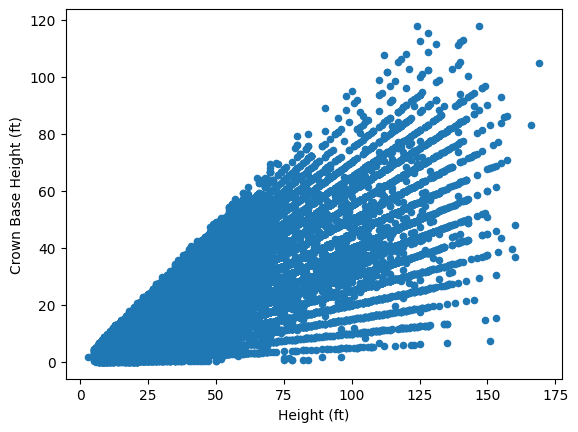

In [9]:
# Compute crown base height from the crown ratio and tree height
fia_data["CBH"] = fia_data["HT"] * (1 - fia_data["CR"] / 100)

# Lastly, lets look at the relationship between crown base height and tree height
fig, ax = plt.subplots()
fia_data.plot.scatter(x="HT", y="CBH", ax=ax)
ax.set_xlabel("Height (ft)")
ax.set_ylabel("Crown Base Height (ft)")
plt.show()


This relationship is quite a bit messier. Maybe there are some other variables that we can use to predict crown base height.

## Predicting Tree Variables

Next, let's train a simple Random Forest Regression model to predict tree diameter from tree height. We'll use the height and diameter data from the FIA database to train the model. We'll then use the model to predict the diameter of the trees detected in the ALS data. Scikit-learn has a great implementation of the Random Forest algorithm that we can use for this task.

In [114]:
# Split into training and test sets
trees_train, trees_test = train_test_split(fia_data[["HT", "DIA"]].dropna(), test_size=0.1)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")
print()

Training set size: 57027
Test set size: 6337



In [53]:
print("n_samples", len(trees_train["DIA"]))
rf = RandomForestRegressor(n_estimators=10)
rf.fit(trees_train[["HT"]], trees_train["DIA"])
print([ est.tree_.weighted_n_node_samples[0] for est in rf.estimators_ ])

n_samples 57027
[57027.0, 57027.0, 57027.0, 57027.0, 57027.0, 57027.0, 57027.0, 57027.0, 57027.0, 57027.0]


In [117]:
# Train the model
features = ["HT"]
model = RandomForestRegressor()
model.fit(trees_train[features], trees_train["DIA"])

# Compute R^2 and RMSE using the test set
print(f"Model R^2: {model.score(trees_test[features], trees_test['DIA']):.2f}")
print(f"Model RMSE: {((model.predict(trees_test[features]) - trees_test['DIA'])**2).mean()**0.5:.2f} inches")

Model R^2: 0.77
Model RMSE: 3.91 inches


In [47]:
df = pd.DataFrame({"HT": [50]})
df.to_numpy()

array([[50]])

In [69]:
model.max_features
trees[ ["HT" ] ]
tmp_list = [15.114830, 31.279529]
import numpy as np
tmp_arr = np.array(tmp_list)
tmp_df = pd.DataFrame({"HT": tmp_list})
model.predict(tmp_df)
# [ est.predict(pd.DataFrame({"HT": [50]}).to_numpy()) for est in model.estimators_ ]
# [ est.tree_.weighted_n_node_samples[0] for est in model.estimators_ ]
# [model.estimators_[i].get_depth() for i in range(model.n_estimators)]

array([3.06414656, 6.5036911 ])

That's pretty good for a simple model! Let's use this model to predict the diameter of the trees detected in the ALS data.

In [15]:
# User our new model to predict the diameter of the trees detected in the ALS data
trees["predicted_diameter"] = model.predict(trees[["HT"]])

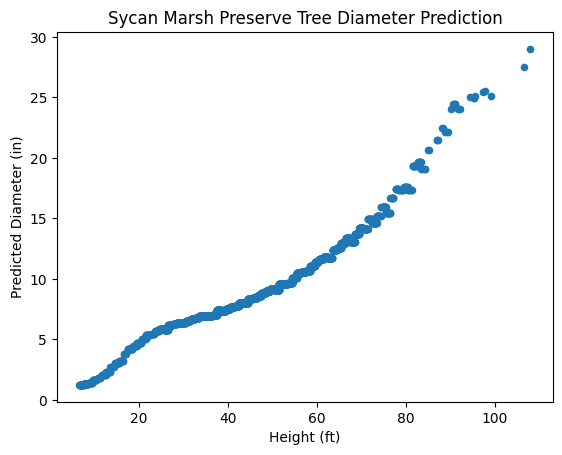

In [16]:
# Plot the predicted diameter
fig, ax = plt.subplots()
trees.plot.scatter(x="HT", y="predicted_diameter", ax=ax)
ax.set_xlabel("Height (ft)")
ax.set_ylabel("Predicted Diameter (in)")
ax.set_title("Sycan Marsh Preserve Tree Diameter Prediction")
plt.show()

In [17]:
# Add the predicted diameter to the folium map
fmap = folium.Map(location=[trees.y.mean(), trees.x.mean()], zoom_start=17)
tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='esri').add_to(fmap)
trees.apply(lambda p: folium.CircleMarker(
    location=(p["y"], p["x"]),
    radius=3, 
    weight=2,
    popup=f"<b>Height:</b> {p.HT:.2f}ft<br><b>Diameter:</b> {p.predicted_diameter:.2f}in",
).add_to(fmap), axis=1)
fmap

## Next steps

We've made some good progress in predicting tree diameter from tree height. Next, we could try additional sets of covariates to improve our estimate of tree diameter. For example, maybe some of the other columns in the FIA database offer important information as to the relationship between height and diameter. Likely the elevation, latitude, or aspect of a tree's location are all important factors in determining how much sunlight a tree receives, and therefore how tall and wide it grows.

Remember the ultimate objective is to predict the following attributes with as much accuracy as possible:
- Diameter (DIA) 
- Crown Base Height (CBH)
- Species (SPCD)

Likely, other models will provide more accurate predictions for these variables. For example, we could use a Gradient Boosting model for improved regression or a clustering algorithm to predict species.


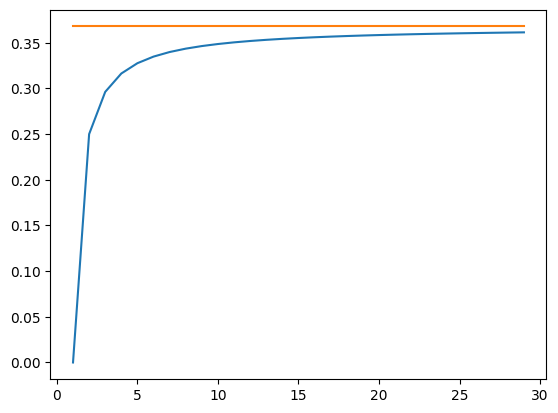

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xs = np.arange(1, 30)
ys = (1 - 1/xs) ** xs
ax.plot(xs, ys)
ax.plot(xs, np.ones_like(xs) / np.e)